In [1]:
using Turing, Plots, LinearAlgebra, Distributions, AdvancedVI, DelimitedFiles, DataFrames

In [2]:
#Generate data
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 40 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 1.0] # Prior mean
V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.2; 
     -0.5 0.8] # Process matrix
H = [1.0 0.0; 
     0.0 1.0] # Observation matrix
Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(2), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

In [3]:
@model function BLDS(y)
    # Generative parameters
    mu_0 = [8.0, 1.0] # Prior mean
    V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
    F = [1.0 0.2; 
         -0.5 0.8] # Process matrix
    H = [1.0 0.0; 
         0.0 1.0] # Observation matrix
    Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
    R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance
    T = 40 # Number of timepoints
    
    # Priors
    a ~ MvNormal(zeros(4),diagm(0=>ones(4)))
    x = Vector{Vector}(undef,T)
    x[1] ~ MvNormal(mu_0, V_0)
    
    y[1] ~ MvNormal(H*x[1], R) # Observation model
    
    for t = 2:T
        x[t] ~ MvNormal(reshape(a,(2,2))*x[t-1], Q) # Process model
        y[t] ~ MvNormal(H*x[t], R) # Observation model
    end
end

BLDS (generic function with 1 method)

In [4]:
etime1 = @elapsed advi = ADVI(10, 100);
etime2 = @elapsed q = vi(BLDS(y_hat), advi);
total_time = etime1 + etime2

n_its = 10
F_mf = Vector{Float64}(undef, n_its)
F_x = Vector{Float64}(undef, n_its)

F_mf[1] = - AdvancedVI.elbo(advi, q, BLDS(y_hat), 1000);
F_x[1] = total_time

for i=2:n_its
    etime = @elapsed q = vi(BLDS(y_hat), advi, q);
    total_time += etime
    F_mf[i] = - AdvancedVI.elbo(advi, q, BLDS(y_hat), 1000);
    F_x[i] = total_time
end

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 11341811741535977666
└ @ AdvancedVI /home/polyten/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:07
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4100816472772002245
└ @ AdvancedVI /home/polyten/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:04
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4948116323629466776
└ @ AdvancedVI /home/polyten/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:04
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 9190024823995930368
└ @ AdvancedVI /home/polyten/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:04
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 150752412420

LoadError: InterruptException:

In [5]:
a_est = mean(rand(q,1000),dims=2)[1:4]

4-element Array{Float64,1}:
  1.0378140350535556
 -0.45673441777234036
  0.2289134061593313
  0.7996994370288057

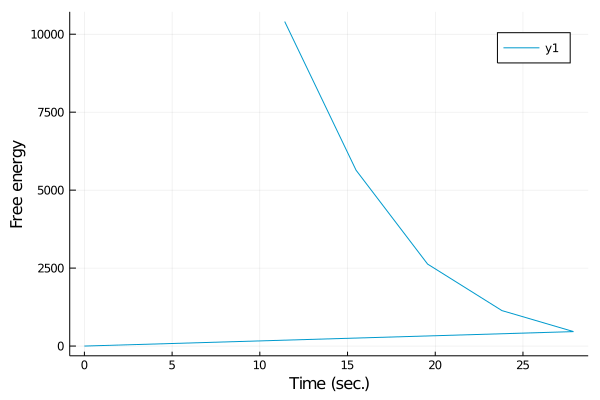

In [6]:
p = plot(F_x, F_mf, color=:deepskyblue3)
ylabel!("Free energy")
xlabel!("Time (sec.)")
p

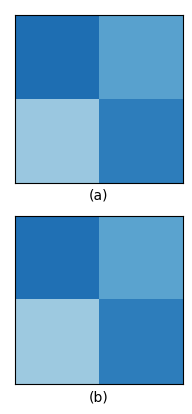

In [7]:
F_est = reshape(a_est,(2,2))

using PyPlot
fig = figure()
g, axes = subplots(nrows=2, ncols=1)
fs = [F_est, F]
titles = ["(a)", "(b)"]

for (i,ax) in enumerate(axes)
    img = ax.matshow(fs[i], cmap="Blues", vmin=-2.0, vmax=2.0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(titles[i])
end

In [8]:
F_mf[end]

6.950322167953e-310

In [9]:
writedlm("ADVIFreeEnergy.txt", F_mf)
writedlm("ADVIFETime.txt", F_x)